# Importing the required Keras dependancies

In [18]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
import keras
from keras import regularizers, optimizers
from keras.layers import Conv2D,Input,Dense,MaxPooling2D,BatchNormalization,ZeroPadding2D,Flatten,Dropout
from keras.models import Model
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint

# Other dependancies

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy.random import permutation

In [20]:
def LeNet_Model():
    # creating a sequential model
    model = Sequential()
    
    # adding first set of CONV -> RELU -> POOL
    model.add(Convolution2D(20, 5, 5, border_mode="same",input_shape=(60, 60,3))) # 3,60,60 tha pehle
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # adding second set of CONV -> RELU -> POOL
    model.add(Convolution2D(50, 5, 5, border_mode="same"))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2, 2),dim_ordering='th')) # specifying the order of dimensions

    # adding set of FC -> RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
 
    # adding softmax classifier
    model.add(Dense(7))          # 7 categories
    model.add(Dropout(0.2))
    model.add(Activation("softmax"))
        
    return model

# Creating the model

In [21]:
model= LeNet_Model()

c:\users\tanmay jain\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (5, 5), input_shape=(60, 60, 3..., padding="same")`
  
c:\users\tanmay jain\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (5, 5), padding="same")`
  if sys.path[0] == '':
c:\users\tanmay jain\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first")`
  from ipykernel import kernelapp as app


# Creating a summary of various layers and total parameters

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 60, 20)        1520      
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60, 20)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 60, 60, 20)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 50)        25050     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30, 50)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 50)       

# Loading the train images and labels

In [23]:
train_images = np.load('train_images_lenet.npy')
train_labels = np.load('train_labels_lenet.npy')

In [24]:
train_images.shape # 6359 images of 60x60 resolution and 3 channels

(6359, 60, 60, 3)

In [25]:
train_labels.shape

(6359,)

In [26]:
np.unique(train_labels)
np.bincount(train_labels)

array([ 591,  592,  590,   24,  372,  592, 3598], dtype=int64)

# Callbacks

In [27]:
# Reduce learning rate when a metric has stopped improving.
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)

# Callback that streams epoch results to a csv file
csv_logger = CSVLogger('Lenet.csv')

# Stop training when a monitored quantity has stopped improving.
early_stopper = EarlyStopping(min_delta=0.001,patience=30)

# Save the model after every epoch.
model_checkpoint = ModelCheckpoint('Lenet.hdf5',monitor = 'val_loss', verbose = 1,save_best_only=True)

In [28]:
# Test pretrained model
train_images = np.array(train_images)
train_labels = np.array(train_labels)
mean = np.mean(train_images,axis=(0,1,2,3))
std = np.std(train_images,axis=(0,1,2,3))
train_images = (train_images-mean)/(std+1e-7)
num_classes = 7
train_labels = np_utils.to_categorical(train_labels-1,num_classes)

In [29]:
train_images.shape, train_labels.shape

((6359, 60, 60, 3), (6359, 7))

# Randomly distributing train_images to make train_images and val_images

In [30]:
perm = permutation(len(train_images))
train_images = train_images[perm]
train_labels = train_labels[perm]
new_train = train_images[1:4800]
new_labels = train_labels[1:4800]
val_images= train_images[4800:]
val_labels = train_labels[4800:]

In [31]:
new_train.shape,val_images.shape

((4799, 60, 60, 3), (1559, 60, 60, 3))

# Compiling the model

In [32]:
model.compile(loss='categorical_crossentropy',
        optimizer="Adam",
        metrics=['accuracy'])

# Preprocessing and data augmentation

In [33]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Fitting the train data

In [34]:
datagen.fit(new_train)
history = model.fit_generator(datagen.flow(new_train, new_labels, batch_size=12),
                        steps_per_epoch=new_train.shape[0] // 12,
                        epochs=30,
                        verbose=1,
                        validation_data=(val_images,val_labels))

Epoch 1/30
399/399 [==============================] - 82s 207ms/step - loss: 0.8167 - accuracy: 0.6915 - val_loss: 0.3392 - val_accuracy: 0.8948
Epoch 2/30
399/399 [==============================] - 84s 211ms/step - loss: 0.5053 - accuracy: 0.7859 - val_loss: 0.2909 - val_accuracy: 0.8974
Epoch 3/30
399/399 [==============================] - 84s 211ms/step - loss: 0.4224 - accuracy: 0.8099 - val_loss: 0.1932 - val_accuracy: 0.9294
Epoch 4/30
399/399 [==============================] - 85s 213ms/step - loss: 0.4000 - accuracy: 0.8141 - val_loss: 0.1891 - val_accuracy: 0.9391
Epoch 5/30
399/399 [==============================] - 83s 208ms/step - loss: 0.3507 - accuracy: 0.8306 - val_loss: 0.1468 - val_accuracy: 0.9500
Epoch 6/30
399/399 [==============================] - 223s 559ms/step - loss: 0.2908 - accuracy: 0.8525 - val_loss: 0.1941 - val_accuracy: 0.9352
Epoch 7/30
399/399 [==============================] - 85s 213ms/step - loss: 0.3416 - accuracy: 0.8377 - val_loss: 0.1280 - val_a

In [35]:
import matplotlib.pyplot as plt 

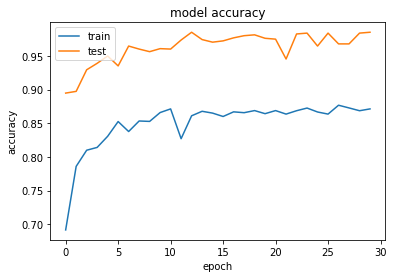

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

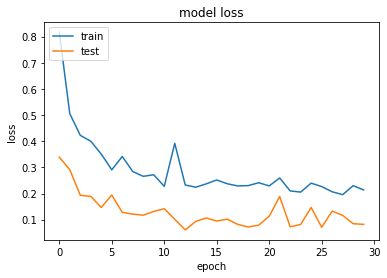

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Saving the model

In [38]:
model.save('Tomato_diseases.h5')

# Loading the saved model

In [39]:
from keras.models import load_model

loaded_model= load_model('Tomato_diseases.h5')
loaded_model

In [40]:
class_names = {0:'bacterial_spot',1:'Healthy',2:'late_blight',3:'leaf_mold',4:'mosaic_virus',5:'septorial_leaf_spot',
               6:'yellow_curved'}

# Testing the model with random images of leaves

In [45]:
#path = r'C:\Users\Tanmay Jain\Desktop\tomato_disease_detection\dataset\septoriaLeafSpot\sep20.jpg'
path = r'C:\Users\Tanmay Jain\Desktop\tomato_disease_detection\dataset\yellowcurved\y1.jpg'
#path = r'C:\Users\Tanmay Jain\Desktop\tomato_disease_detection\dataset\Healthy\l2.png'
input_img= cv2.imread(path,1)
#cv2.imshow('image',input_img)
#print(input_img)
if input_img is not None:
    img = cv2.resize(input_img, (60,60)).astype(np.float32)
            
else:
    print("image not loaded")
    
img = (img-mean)/(std+1e-7)
img = np.expand_dims(img, axis=0)  
out = loaded_model.predict(img) 
print(out)
print(np.argmax(out))
print(class_names[np.argmax(out)+1])
# Correct!

[[1.4761086e-20 2.9160475e-14 1.1559460e-25 1.0085815e-15 1.4715865e-15
  1.0000000e+00 3.3229973e-14]]
5
yellow_curved


In [74]:
#path = r'C:\Users\Tanmay Jain\Desktop\tomato_disease_detection\dataset\septoriaLeafSpot\sep20.jpg'
#input_img= cv2.imread('dataset\late_blight\Il0.png', 1)
path= r'C:\Users\Tanmay Jain\Desktop\Datasets\tomato-disease-detection\dataset\ healthy\h587.png'
input_img1= cv2.imread(path,1)


if input_img1 is not None:
    img = cv2.resize(input_img1,(60,60)).astype(np.float32)
else:
    print("image not loaded")
    
img = (img-mean)/(std+1e-7)
img = np.expand_dims(img, axis=0)  
out = loaded_model.predict(img) 
print(out)
print(np.argmax(out))
print(class_names[np.argmax(out)])
# Correct

[[9.9999440e-01 5.0773920e-06 1.6903053e-13 6.8682126e-13 5.6567009e-09
  3.3427767e-07 1.2227036e-07]]
0
bacterial_spot
